# Analysis of the regional distribution of candidate affinity-enhancing and -diminishing mutations (related to Figure 5)

In [12]:
from __future__ import division
import sys
import os
import time
import copy
import pickle

import numpy as np
import pandas as pd
import scipy

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns

output_dir = "outs"
output_suffix = ""
output_formats = [".pdf", ".png"]

def save_figure(fig, name, output_dir, output_suffix, output_formats, savefig_args):
    if savefig:
        for output_format in output_formats:
            fig.savefig(output_dir + "/" + name + output_suffix + output_format, **savefig_args)
    return None

savefig = True
savefig_args = {"dpi": 300, "bbox_inches": "tight", "pad_inches": 0.2}
mpl.rc('savefig', dpi=300)

sns.set_style("ticks")
sns.set_context("talk")

myColors = ["#E69F00", "#56B4E9", "#D55E00", "#009E73"]

# Load data on fitness changes and mutations

In [13]:
df_fitness = pd.read_csv("data/FitnessMutations.df_fitness.csv", header=0, index_col=0)
print df_fitness.shape

(460029, 11)


In [27]:
df_mutations = pd.read_csv("data/FitnessMutations.df_mutations.csv", header=0, index_col=0)
print df_mutations.shape

(20636634, 8)


In [28]:
# Lineage dynamics data (to subset lineages)
df_expanded = pd.read_csv("data/df_expanded.filtered.csv", index_col=0)

In [29]:
# Subset to expanded lineages
df_fitness = df_fitness.loc[df_fitness["lineage_uid"].isin(df_expanded.index)]
print df_fitness.shape

df_mutations = df_mutations.loc[df_mutations["lineage_uid"].isin(df_expanded.index)]
print df_mutations.shape

(200142, 11)
(8034151, 8)


In [30]:
# Remove indels
df_mutations = df_mutations.loc[df_mutations["base_after"] != "-"]
print df_mutations.shape

# Note there are no insertions
print df_mutations.loc[df_mutations["base_before"] == "-"].shape

(92715, 8)
(0, 8)


# Take a peek at mutations

In [31]:
df_fitness.head()

,name,depth,mean_fitness,var_fitness,parent_name,parent_depth,parent_mean_fitness,parent_var_fitness,delta_mean_fitness,length,lineage_uid
0,4_,0.04164,6.103610,0.142752,2_,0.00559,4.022596,0.382973,2.081014,0.03605,20201010000000500
1,112_,0.20237,5.510416,0.394547,76_,0.13873,3.436856,0.460586,2.073560,0.06364,20201010000000500
2,11_,0.04752,6.479766,0.033968,7_,0.04219,6.145991,0.131112,0.333775,0.00533,20201010000000500
3,215_,0.20826,5.687386,0.368066,157_,0.20292,5.534411,0.390708,0.152975,0.00534,20201010000000500
4,35_,0.10844,3.409644,0.531039,25_,0.09046,3.282202,0.540436,0.127442,0.01798,20201010000000500


In [32]:
df_fitness.sort_values("delta_mean_fitness", ascending=False).head()

,name,depth,mean_fitness,var_fitness,parent_name,parent_depth,parent_mean_fitness,parent_var_fitness,delta_mean_fitness,length,lineage_uid
90718,4_,0.18688,5.845708,0.169795,2_,0.04706,1.342103,0.314526,4.503605,0.13982,80201010000000675
56033,4_,0.17496,6.213930,0.097679,2_,0.04882,2.461083,0.430116,3.752847,0.12614,60201010000000781
111176,19_,0.10857,5.638111,0.256828,14_,0.05668,2.048099,0.330684,3.590012,0.05189,70201010000000214
72214,9_,0.13392,5.744336,0.224477,6_,0.11329,2.281537,0.308108,3.462799,0.02063,60201010000000583
285450,12_,0.09712,5.480815,0.311784,8_,0.02970,2.078398,0.381001,3.402417,0.06742,70201010000009999


In [33]:
df_mutations.head()

,name,parent_name,position,base_before,base_after,coding_status,region,lineage_uid
19,29900000000169111,3_,309.0,T,G,N,CDR3,20201010000000500
20,29900000000169111,3_,313.0,G,A,N,CDR3,20201010000000500
21,29900000000169111,3_,316.0,C,G,N,CDR3,20201010000000500
22,29900000000169111,3_,317.0,G,C,S,CDR3,20201010000000500
23,29900000000169111,3_,319.0,G,A,N,CDR3,20201010000000500


In [21]:
# Get mutations along one branch
selector = ((df_mutations["lineage_uid"] == 80201010000000675) &
            (df_mutations["name"] == "4_") &
            (df_mutations["parent_name"] == "2_"))
# df_mutations.loc[selector]["region"].value_counts(normalize=True)
df_mutations.loc[selector]["region"].value_counts()

CDR3    21
CDR2    11
FWR3     9
FWR2     6
FWR1     3
CDR1     1
FWR4     1
Name: region, dtype: int64

In [22]:
# Distribution of mutations across regions among ALL branches
df_mutations["region"].value_counts(normalize=True)

CDR3    0.381827
FWR3    0.281235
FWR1    0.104740
FWR2    0.070419
CDR2    0.063041
CDR1    0.053667
FWR4    0.045070
Name: region, dtype: float64

In [23]:
# Test enrichment of one branch
df_mutations.loc[selector]["region"].value_counts(normalize=True) / df_mutations["region"].value_counts(normalize=True)

CDR1    0.358336
CDR2    3.355552
CDR3    1.057669
FWR1    0.550812
FWR2    1.638542
FWR3    0.615417
FWR4    0.426684
Name: region, dtype: float64

# Define functions to get mutations by fitness percentile

In [34]:
# Split mutations into N and S
df_mutations_N = df_mutations.loc[df_mutations["coding_status"] == "N"]
df_mutations_S = df_mutations.loc[df_mutations["coding_status"] == "S"]

In [35]:
# Count mutations in each region for each branch, index result by branch
counts_all = df_mutations.groupby(["lineage_uid", "name", "parent_name"])["region"].value_counts(normalize=False)
counts_all_N = df_mutations_N.groupby(["lineage_uid", "name", "parent_name"])["region"].value_counts(normalize=False)
counts_all_S = df_mutations_S.groupby(["lineage_uid", "name", "parent_name"])["region"].value_counts(normalize=False)

In [392]:
# Remove fitness branches for which we do not have mutation data or there are no mutations

start_time = time.time()

muts_indexes = zip(counts_all.index.get_level_values(0),
                   counts_all.index.get_level_values(1),
                   counts_all.index.get_level_values(2))

def make_is_in_muts(df_fitness, muts_indexes):
    """ For each row in df_fitness, determine if index exists in muts_indexes """
    is_present = []
    for _, row in df_fitness.iterrows():
        my_is_present = (row["lineage_uid"], row["name"], row["parent_name"]) in muts_indexes
        is_present.append(my_is_present)
    return is_present

# Determine whether each row is present in muts
# Takes a while (hours?)
is_present = make_is_in_muts(df_fitness, muts_indexes)

df_fitness_clean = df_fitness.iloc[is_present]
print df_fitness_clean.shape

print time.time() - start_time, "s"

(33994, 11)
1205.42371416 s


In [393]:
# Remove fitness branches for which we do not have mutation data for N and S separately

start_time = time.time()

muts_indexes_N = zip(counts_all_N.index.get_level_values(0),
                     counts_all_N.index.get_level_values(1),
                     counts_all_N.index.get_level_values(2))
is_present_N = make_is_in_muts(df_fitness, muts_indexes_N)

df_fitness_N_clean = df_fitness.iloc[is_present_N]
print df_fitness_N_clean.shape

print time.time() - start_time, "s"
print

start_time = time.time()

muts_indexes_S = zip(counts_all_S.index.get_level_values(0),
                     counts_all_S.index.get_level_values(1),
                     counts_all_S.index.get_level_values(2))
is_present_S = make_is_in_muts(df_fitness, muts_indexes_S)

df_fitness_S_clean = df_fitness.iloc[is_present_S]
print df_fitness_S_clean.shape

print time.time() - start_time, "s"
print

(27399, 11)
948.134649992 s

(13722, 11)
478.720921993 s



In [394]:
# # Write outputs to file (to avoid rerunning long computation)
# df_fitness_clean.to_csv("data/FitnessMutations.df_fitness_clean.csv")
# df_fitness_N_clean.to_csv("data/FitnessMutations.df_fitness_N_clean.csv")
# df_fitness_S_clean.to_csv("data/FitnessMutations.df_fitness_S_clean.csv")

In [4]:
# Load results from files (rerunning takes a while)
df_fitness_clean = pd.read_csv("data/FitnessMutations.df_fitness_clean.csv")
df_fitness_N_clean = pd.read_csv("data/FitnessMutations.df_fitness_N_clean.csv")
df_fitness_S_clean = pd.read_csv("data/FitnessMutations.df_fitness_S_clean.csv")

In [5]:
# Sort branches by fitness change
df_fitness_clean_sorted = df_fitness_clean.sort_values("delta_mean_fitness", ascending=False)
df_fitness_N_clean_sorted = df_fitness_N_clean.sort_values("delta_mean_fitness", ascending=False)
df_fitness_S_clean_sorted = df_fitness_S_clean.sort_values("delta_mean_fitness", ascending=False)

# Get mutations from best and worst branches ranked by fitness change

In [6]:
def rank_branches_within_lineages(df_fitness_sorted):
    """ Rank each branch within its lineage """
    
    start_time = time.time()
    
    current_rank = {}
    for lineage_uid in df_fitness_sorted["lineage_uid"].value_counts().index:
        current_rank[lineage_uid] = 1
    
    df_fitness_sorted["rank"] = 0
    
    for ix, row in df_fitness_sorted.iterrows():
        df_fitness_sorted.loc[ix,"rank"] = current_rank[row["lineage_uid"]]
        current_rank[row["lineage_uid"]] += 1
    
    print "Elapsed time (s):", time.time() - start_time
    
    return df_fitness_sorted

In [7]:
def get_region_counts_for_ranks(df_fitness_sorted_ranked, counts_by_branch, ranks):
    """ Count mutations in each region for branches within the chosen ranks (e.g. top 5) """

    # Get branches from each lineage within ranks
    df = df_fitness_sorted_ranked.loc[df_fitness_sorted_ranked["rank"].isin(ranks)]

    counts = {}
    for region in ["CDR1", "CDR2", "CDR3", "FWR1", "FWR2", "FWR3", "FWR4"]:
        counts[region] = 0

    for _, row in df.iterrows():
        my_counts = counts_by_branch.loc[row["lineage_uid"], row["name"], row["parent_name"] ]
        for region in my_counts.index:
            counts[region] += my_counts[region]

    counts = pd.Series(counts)
    return counts

In [8]:
# Rank branches
df_fitness_N_clean_sorted_ranked = rank_branches_within_lineages(df_fitness_N_clean_sorted.head(n=1000))
df_fitness_S_clean_sorted_ranked = rank_branches_within_lineages(df_fitness_S_clean_sorted.head(n=1000))

/local10G/rfhorns/resources/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/local10G/rfhorns/resources/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Elapsed time (s): 50.2114081383
Elapsed time (s): 50.0621109009


In [9]:
# Sort in reverse (worst branches are at the top)
df_fitness_N_clean_sortedRev = df_fitness_N_clean.sort_values("delta_mean_fitness", ascending=True)
df_fitness_S_clean_sortedRev = df_fitness_S_clean.sort_values("delta_mean_fitness", ascending=True)

# Rank in reverse (worst branch is rank 1)
df_fitness_N_clean_sortedRev_ranked = rank_branches_within_lineages(df_fitness_N_clean_sortedRev.head(n=1000))
df_fitness_S_clean_sortedRev_ranked = rank_branches_within_lineages(df_fitness_S_clean_sortedRev.head(n=1000))

/local10G/rfhorns/resources/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Elapsed time (s): 50.1687591076
Elapsed time (s): 50.1362760067


In [37]:
# Choose a range

my_range = range(1,4)

print "Top", max(my_range)

# Calculate distribution of mutations across regions

counts_topRanks_N = get_region_counts_for_ranks(df_fitness_N_clean_sorted_ranked, counts_all_N, ranks=my_range)
counts_topRanks_N_normed = counts_topRanks_N / sum(counts_topRanks_N)
counts_topRanks_N_normed_enrich = counts_topRanks_N_normed / df_mutations["region"].value_counts(normalize=True)

counts_topRanks_S = get_region_counts_for_ranks(df_fitness_S_clean_sorted_ranked, counts_all_S, ranks=my_range)
counts_topRanks_S_normed = counts_topRanks_S / sum(counts_topRanks_S)
counts_topRanks_S_normed_enrich = counts_topRanks_S_normed / df_mutations["region"].value_counts(normalize=True)

counts_topRanks_dNdS = counts_topRanks_N_normed/counts_topRanks_S_normed

# dN/dS
print "Best"
print counts_topRanks_dNdS
print

# Calculate distribution of mutations across region
counts_bottomRanks_N = get_region_counts_for_ranks(df_fitness_N_clean_sortedRev_ranked, counts_all_N, ranks=my_range)
counts_bottomRanks_N_normed = counts_bottomRanks_N / sum(counts_bottomRanks_N)
counts_bottomRanks_N_normed_enrich = counts_bottomRanks_N_normed / df_mutations["region"].value_counts(normalize=True)

counts_bottomRanks_S = get_region_counts_for_ranks(df_fitness_S_clean_sortedRev_ranked, counts_all_S, ranks=my_range)
counts_bottomRanks_S_normed = counts_bottomRanks_S / sum(counts_bottomRanks_S)
counts_bottomRanks_S_normed_enrich = counts_bottomRanks_S_normed / df_mutations["region"].value_counts(normalize=True)

counts_bottomRanks_dNdS = counts_bottomRanks_N_normed/counts_bottomRanks_S_normed

# dN/dS
print "Worst"
print counts_bottomRanks_dNdS

Top 3
Best
CDR1    1.531425
CDR2    1.257508
CDR3    1.241597
FWR1    0.606387
FWR2    1.028984
FWR3    0.570378
FWR4    0.542527
dtype: float64

Worst
CDR1    1.007634
CDR2    0.889805
CDR3    1.301841
FWR1    0.958580
FWR2    0.682564
FWR3    0.844248
FWR4    0.846154
dtype: float64


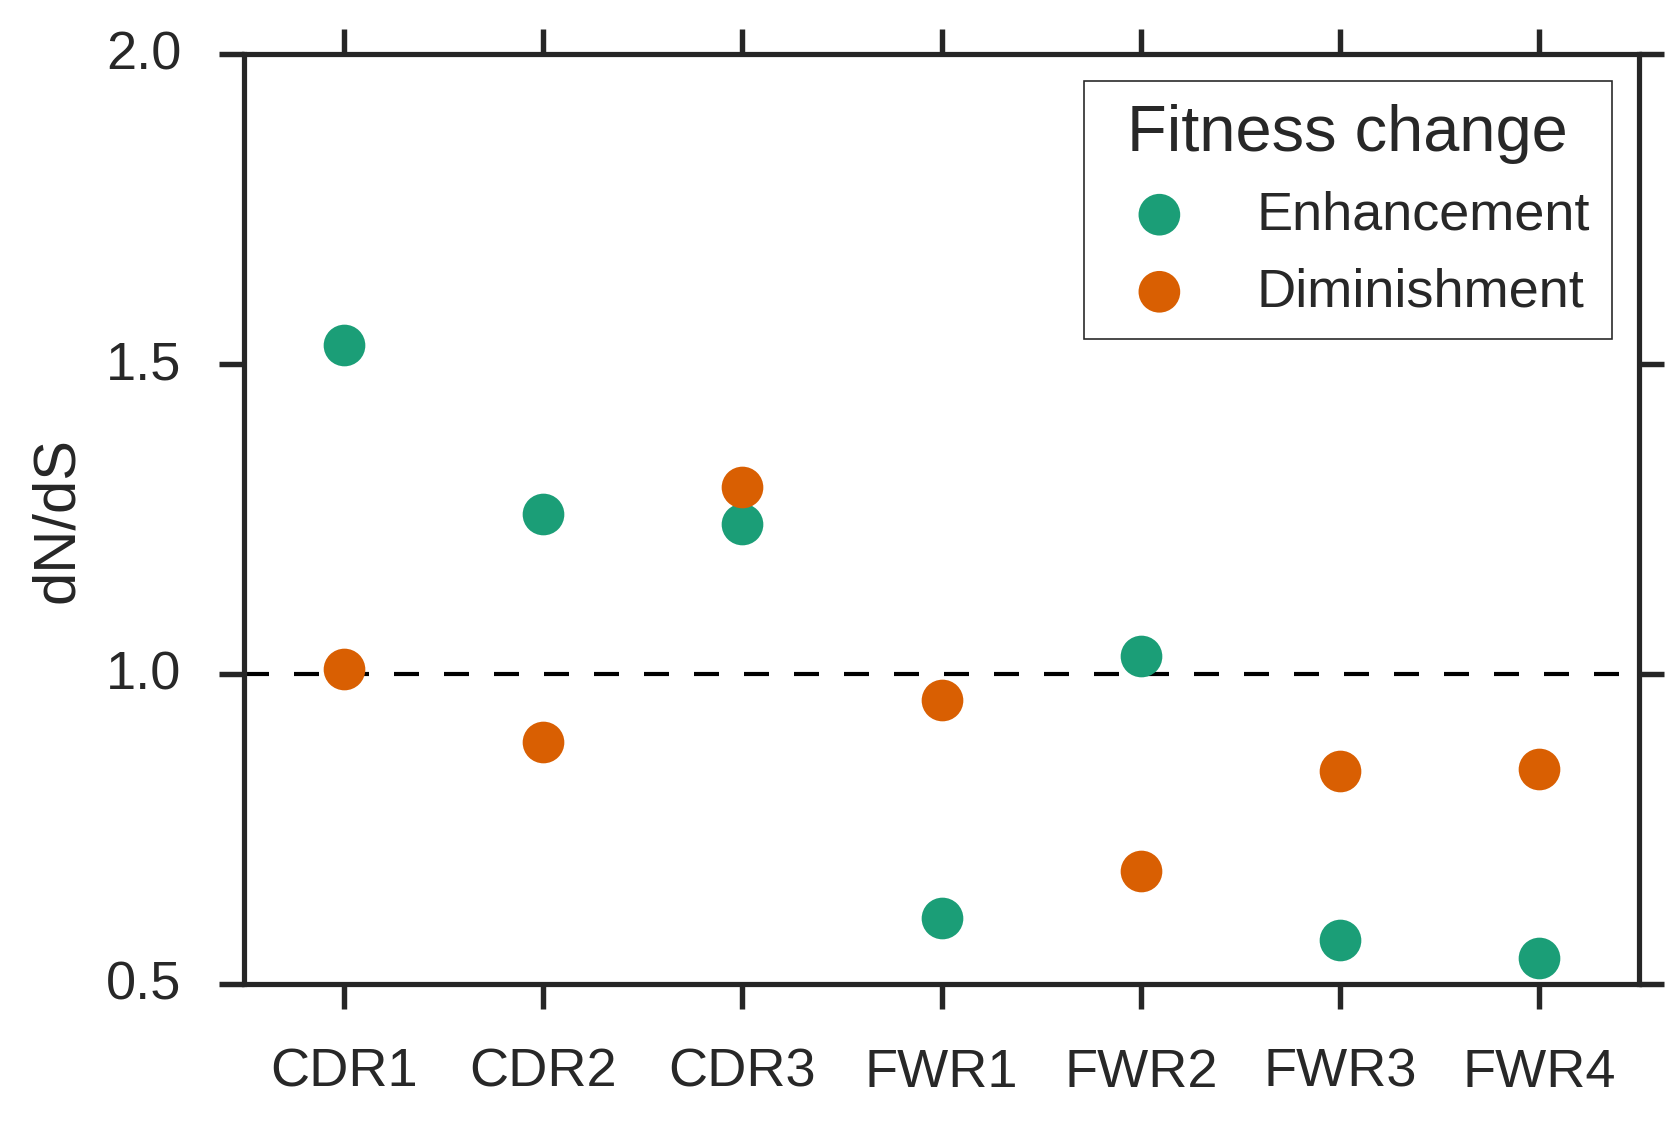

In [313]:
# Plot dN/dS across regions

fig, ax = plt.subplots(1, 1, figsize=(6,4))

x = np.array(range(len(counts_topRanks_dNdS)))
y = counts_topRanks_dNdS
ax.scatter(x, y, c="#1b9e77", label="Enhancement", s=100, lw=0)

x = np.array(range(len(counts_bottomRanks_dNdS)))
y = counts_bottomRanks_dNdS
ax.scatter(x, y, c="#d95f02", label="Diminishment", s=100, lw=0)

ax.set_xlim(-0.5, max(x)+0.5)
ax.set_ylim(0.5,2)
ax.set_yticks([0.5, 1, 1.5, 2])
ax.set_xticklabels(["", "CDR1", "CDR2", "CDR3", "FWR1", "FWR2", "FWR3", "FWR4"])
ax.axhline(1, linestyle="--", color="k", zorder=-1, lw=1)

ax.set_ylabel("dN/dS")
ax.legend(loc="upper right", title="Fitness change", frameon=True)

# save_figure(fig, "FitnessMutations_TopBottom1Percent_Region", output_dir, output_suffix, output_formats, savefig_args)

# Bootstrap error bars

In [329]:
def get_region_counts_for_ranks_bootstrap(df_fitness_sorted_ranked, counts_by_branch, ranks, n_reps=100):
    """ Count mutations in each region for branches within the chosen ranks (e.g. top 5) """

    regions = ["CDR1", "CDR2", "CDR3", "FWR1", "FWR2", "FWR3", "FWR4"]
    
    # Get branches from each lineage within ranks
    df = df_fitness_sorted_ranked.loc[df_fitness_sorted_ranked["rank"].isin(ranks)]
    
    df_counts = pd.DataFrame(columns=regions)
    
    for i in xrange(n_reps):
        
        # Sample rows with replacement
        df_sampled = df.sample(n=df.shape[0], replace=True)
        
        counts = {}
        for region in regions:
            counts[region] = 0

        for _, row in df_sampled.iterrows():
            my_counts = counts_by_branch.loc[row["lineage_uid"], row["name"], row["parent_name"] ]
            for region in my_counts.index:
                counts[region] += my_counts[region]

        counts = pd.Series(counts)
        df_counts = df_counts.append(counts, ignore_index=True)
        
    return df_counts

In [348]:
# Bootstrap by resampling branches

my_range = range(1,4)
n_reps = 100

start_time = time.time()

counts_topRanks_N_bootstraps = get_region_counts_for_ranks_bootstrap(df_fitness_N_clean_sorted_ranked, counts_all_N, ranks=my_range, n_reps=n_reps)
counts_topRanks_S_bootstraps = get_region_counts_for_ranks_bootstrap(df_fitness_S_clean_sorted_ranked, counts_all_S, ranks=my_range, n_reps=n_reps)

print "Elapsed time (s):", time.time() - start_time

counts_topRanks_N_bootstraps_normed = counts_topRanks_N_bootstraps.div(counts_topRanks_N_bootstraps.sum(axis=1), axis=0)
counts_topRanks_S_bootstraps_normed = counts_topRanks_S_bootstraps.div(counts_topRanks_S_bootstraps.sum(axis=1), axis=0)

counts_topRanks_dNdS_bootstraps = counts_topRanks_N_bootstraps_normed / counts_topRanks_S_bootstraps_normed

In [371]:
start_time = time.time()

counts_bottomRanks_N_bootstraps = get_region_counts_for_ranks_bootstrap(df_fitness_N_clean_sorted_ranked, counts_all_N, ranks=my_range, n_reps=n_reps)
counts_bottomRanks_S_bootstraps = get_region_counts_for_ranks_bootstrap(df_fitness_S_clean_sorted_ranked, counts_all_S, ranks=my_range, n_reps=n_reps)

print "Elapsed time (s):", time.time() - start_time

counts_bottomRanks_N_bootstraps_normed = counts_bottomRanks_N_bootstraps.div(counts_bottomRanks_N_bootstraps.sum(axis=1), axis=0)
counts_bottomRanks_S_bootstraps_normed = counts_bottomRanks_S_bootstraps.div(counts_bottomRanks_S_bootstraps.sum(axis=1), axis=0)

counts_bottomRanks_dNdS_bootstraps = counts_bottomRanks_N_bootstraps_normed / counts_bottomRanks_S_bootstraps_normed

Elapsed time (s): 65.9620001316


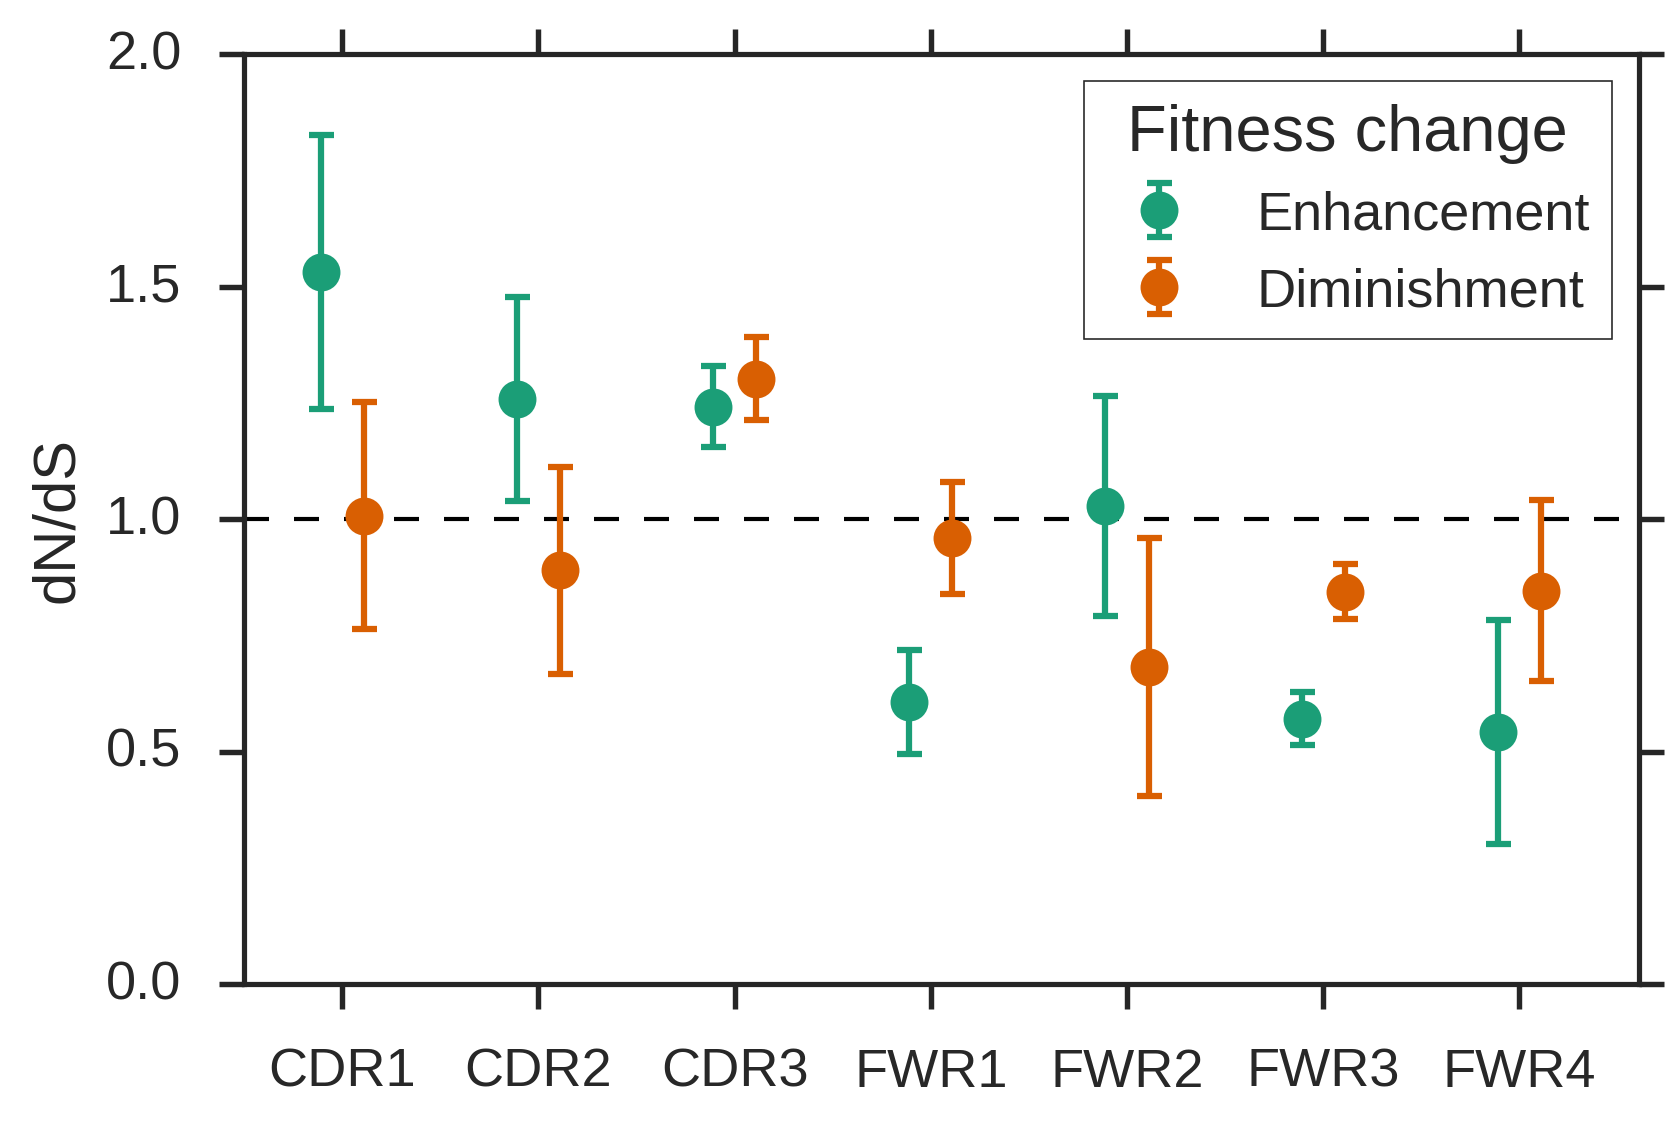

In [377]:
# Plot dN/dS across regions

fig, ax = plt.subplots(1, 1, figsize=(6,4))

x = np.array(range(len(counts_topRanks_dNdS)))-0.11
y = counts_topRanks_dNdS
yerr = np.std(counts_topRanks_dNdS_bootstraps, axis=0)
ax.errorbar(x, y, yerr=yerr, c="#1b9e77", label="Enhancement",
            marker="o", ls="none", capthick=1.5, elinewidth=1.5, capsize=3)

x = np.array(range(len(counts_bottomRanks_dNdS)))+0.11
y = counts_bottomRanks_dNdS
yerr = np.std(counts_bottomRanks_dNdS_bootstraps, axis=0)
ax.errorbar(x, y, yerr=yerr, c="#d95f02", label="Diminishment",
            marker="o", ls="none", capthick=1.5, elinewidth=1.5, capsize=3)

ax.set_xlim(-0.5, max(x)+0.5)
ax.set_ylim(0,2)
ax.set_yticks([0, 0.5, 1, 1.5, 2])
ax.set_xticklabels(["", "CDR1", "CDR2", "CDR3", "FWR1", "FWR2", "FWR3", "FWR4"])
ax.axhline(1, linestyle="--", color="k", zorder=-1, lw=1)

ax.set_ylabel("dN/dS")
ax.legend(loc="upper right", title="Fitness change", frameon=True)

save_figure(fig, "FitnessMutations_TopBottomRanks_Region_ErrorBars", output_dir, output_suffix, output_formats, savefig_args)

In [378]:
# Check statistical significance of enrichment/depletion
def fisher_exact_region(observed, null, region):
    regions = ["FWR1", "FWR2", "FWR3", "FWR4", "CDR1", "CDR2", "CDR3"]
    otherRegions = list(set(regions) - set([region]))
    myContingencyTable = [[observed.loc[region], np.sum(observed.loc[otherRegions])],
                          [null.loc[region], np.sum(null.loc[otherRegions])]]
    _, p = scipy.stats.fisher_exact(myContingencyTable)
    return p

In [379]:
# Top N versus S
regions = ["FWR1", "FWR2", "FWR3", "FWR4", "CDR1", "CDR2", "CDR3"]
for region in regions:
    p = fisher_exact_region(counts_topRanks_N, counts_topRanks_S, region)
    print region, p

FWR1 0.00834545382074
FWR2 0.873830556276
FWR3 1.1280999957e-11
FWR4 0.0118593188656
CDR1 0.00744013251487
CDR2 0.10689378125
CDR3 1.12770172724e-06


In [380]:
# Bottom N versus S
regions = ["FWR1", "FWR2", "FWR3", "FWR4", "CDR1", "CDR2", "CDR3"]
for region in regions:
    p = fisher_exact_region(counts_bottomRanks_N, counts_bottomRanks_S, region)
    print region, p

FWR1 0.671545108972
FWR2 0.000182055118635
FWR3 0.000869467021656
FWR4 0.208637538794
CDR1 0.956756510972
CDR2 0.274687931692
CDR3 7.28275799485e-11
